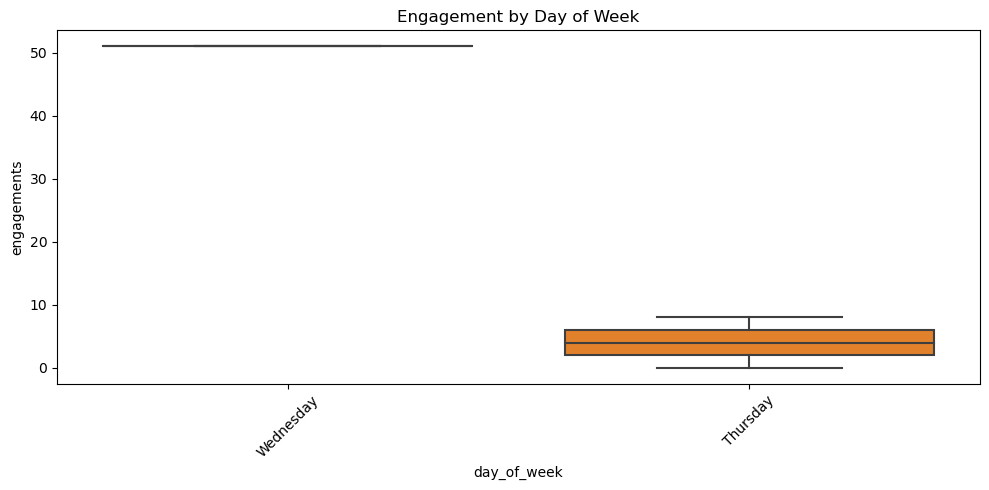

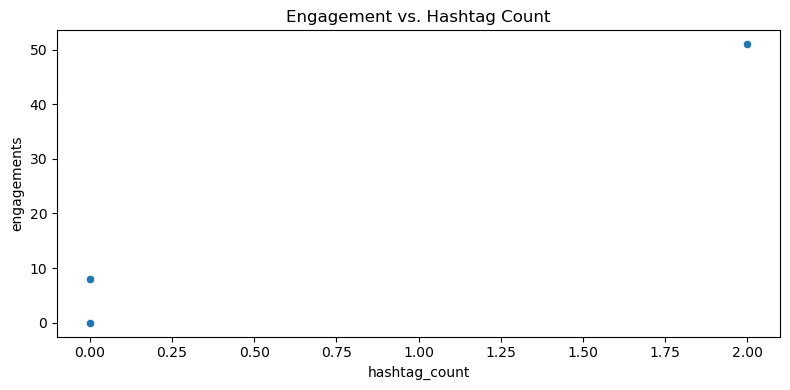

Final dataset exported to: final_merged_social_data.csv

 Sample:
     post_date    museum_name   platform  engagements  hashtag_count  \
113 2024-12-04  Ulster Museum  Instagram         51.0              2   
116 2024-08-01  Ulster Museum  Instagram          0.0              0   
117 2024-08-01  Ulster Museum  Instagram          8.0              0   

     sentiment  
113     0.0000  
116     0.5994  
117     0.5994  


In [33]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# 1. Load Data
# -----------------------------
fb_path = "/Users/faitusjelinejoseph/Documents/Project/Social/Final_Facebook_Posts_With_Captions.xlsx"
ig_path = "/Users/faitusjelinejoseph/Documents/Project/Social/Instagram captions.xlsx"
report_path = "/Users/faitusjelinejoseph/Documents/Project/Social/Digital Engagement Report 2024-25.xlsx"

fb_df = pd.read_excel(fb_path, sheet_name='Sheet1')
ig_df = pd.read_excel(ig_path, sheet_name='Sheet1')
report_data = pd.read_excel(report_path, sheet_name=None)
activity_df = report_data['Social Activity Tracker']

# -----------------------------
# 2. Clean Facebook & Instagram
# -----------------------------
fb_df_cleaned = fb_df.rename(columns={
    'Post Date': 'post_date',
    'Museum Name': 'museum_name',
    'Formatted Facebook Caption': 'caption'
})
fb_df_cleaned['platform'] = 'Facebook'

ig_df_cleaned = ig_df.rename(columns={
    'Date Posted': 'post_date',
    'Museum Site': 'museum_name',
    'Full Caption': 'caption'
})
ig_df_cleaned['platform'] = 'Instagram'

fb_df_cleaned = fb_df_cleaned[['post_date', 'museum_name', 'caption', 'platform']]
ig_df_cleaned = ig_df_cleaned[['post_date', 'museum_name', 'caption', 'platform']]
combined_posts = pd.concat([fb_df_cleaned, ig_df_cleaned], ignore_index=True)
combined_posts['post_date'] = pd.to_datetime(combined_posts['post_date'], errors='coerce')
combined_posts = combined_posts.dropna(subset=['caption', 'post_date'])

# -----------------------------
# 3. Clean Engagement Report
# -----------------------------
activity_df_cleaned = activity_df.rename(columns={
    'Day': 'day',
    'Month': 'month',
    'Site': 'site',
    'Content Type': 'content_type',
    'Total Active Engagements (Like, Comment, Share, Video >15s)': 'engagements',
    'Total Reach': 'reach'
}).dropna(subset=['site', 'month'])

month_str_to_num = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}
activity_df_cleaned['month'] = activity_df_cleaned['month'].map(month_str_to_num)
activity_df_cleaned['day'] = activity_df_cleaned['day'].fillna(15).astype(int)
activity_df_cleaned['post_date'] = pd.to_datetime({
    'year': 2024,
    'month': activity_df_cleaned['month'],
    'day': activity_df_cleaned['day']
}, errors='coerce')

site_to_museum = {
    'UFM': 'Ulster Museum',
    'UTM': 'Ulster Transport Museum',
    'AFP': 'Ulster American Folk Park',
    'NISM': 'Ulster Folk Museum'
}
activity_df_cleaned['museum_name'] = activity_df_cleaned['site'].map(site_to_museum)
activity_df_cleaned['platform'] = activity_df_cleaned['content_type'].apply(
    lambda x: 'Facebook' if isinstance(x, str) and 'Facebook' in x else 'Instagram'
)

# -----------------------------
# 4. Merge Datasets
# -----------------------------
merged_df = pd.merge(
    combined_posts,
    activity_df_cleaned[['post_date', 'museum_name', 'platform', 'engagements', 'reach']],
    on=['post_date', 'museum_name', 'platform'],
    how='left'
).dropna(subset=['engagements'])

# -----------------------------
# 5. Feature Engineering
# -----------------------------
merged_df['hashtag_count'] = merged_df['caption'].fillna('').apply(lambda x: x.count('#'))
merged_df['hour_of_day'] = merged_df['post_date'].dt.hour
merged_df['day_of_week'] = merged_df['post_date'].dt.day_name()
merged_df['month'] = merged_df['post_date'].dt.month

# Sentiment
nltk.download('vader_lexicon', quiet=True)
sia = SentimentIntensityAnalyzer()
merged_df['sentiment'] = merged_df['caption'].fillna('').apply(lambda x: sia.polarity_scores(x)['compound'])

# -----------------------------
# 6. Data Visualizations
# -----------------------------

# Engagement by Day of Week
plt.figure(figsize=(10, 5))
sns.boxplot(x='day_of_week', y='engagements', data=merged_df)
plt.title('Engagement by Day of Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Hashtag Count vs Engagement
plt.figure(figsize=(8, 4))
sns.scatterplot(x='hashtag_count', y='engagements', data=merged_df)
plt.title('Engagement vs. Hashtag Count')
plt.tight_layout()
plt.show()



# -----------------------------
# 7. Export Cleaned Dataset
# -----------------------------
merged_df.to_csv("/Users/faitusjelinejoseph/Documents/Project/Social/final_merged_social_data.csv", index=False)
print("Final dataset exported to: final_merged_social_data.csv")

# Preview sample rows
print("\n Sample:")
print(merged_df[['post_date', 'museum_name', 'platform', 'engagements', 'hashtag_count', 'sentiment']].head())





In [32]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ---------------------------------
# 1. Load Data
# ---------------------------------
file_path = "/Users/faitusjelinejoseph/Documents/Project/Social/feature_engineered_posts.csv"
df = pd.read_csv(file_path, parse_dates=['post_date'])
df = df.dropna(subset=["engagements"])

print("Data Loaded: ", df.shape)

# ---------------------------------
# 2. Basic Validation
# ---------------------------------
print("\n Engagement Distribution:")
print(df['engagements'].describe())
if df['engagements'].nunique() <= 1:
    raise ValueError("Engagement column has no variation.")

# Drop 'reach' if it's empty or constant
if 'reach' in df.columns and df['reach'].nunique() <= 1:
    df.drop(columns=['reach'], inplace=True)
    print("Dropped 'reach' — constant or missing.")

# ---------------------------------
# 3. Feature Engineering
# ---------------------------------
day_map = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
           'Friday': 4, 'Saturday': 5, 'Sunday': 6}
df['day_of_week'] = df['day_of_week'].map(day_map)

# Hashtags
df["hashtags"] = df["caption"].fillna("").apply(lambda x: re.findall(r"#\w+", x.lower()))
hashtag_df = df.explode("hashtags")
hashtag_engagement = (
    hashtag_df.groupby("hashtags")["engagements"]
    .mean()
    .reset_index()
    .sort_values(by="engagements", ascending=False)
)

# Sentiment
nltk.download('vader_lexicon', quiet=True)
sia = SentimentIntensityAnalyzer()
df["sentiment_score"] = df["caption"].fillna("").apply(lambda x: sia.polarity_scores(x)["compound"])

# One-hot encode categorical features
df = pd.get_dummies(df, columns=["museum_name", "platform"], drop_first=True)

# ---------------------------------
# 4. Validate TF-IDF Features
# ---------------------------------
tfidf_cols = [col for col in df.columns if col.startswith("tfidf_")]
nonzero_tfidf = sum(df[tfidf_cols].sum() > 0)
print(f"\n Non-zero TF-IDF features: {nonzero_tfidf}")
if nonzero_tfidf == 0:
    print(" TF-IDF features are all zeros — captions may be empty or bad vectorization.")

# ---------------------------------
# 5. LightGBM Training
# ---------------------------------
drop_cols = ['post_date', 'caption', 'season', 'hashtags']
X = df.drop(columns=drop_cols + ['engagements'], errors='ignore')
y = df['engagements']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LGBMRegressor(random_state=42, verbose=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n Model Evaluation:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# -----------------------------
# 6. Feature Importance Plot
# -----------------------------
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

non_zero_features = feature_importance[feature_importance["Importance"] > 0]

if non_zero_features.empty:
    print(" No features have non-zero importance. Model may be underfitting.")
else:
    top_features = non_zero_features.head(15)
    print("\n Top Features:")
    print(top_features)

    plt.figure(figsize=(10, 6))
    plt.barh(y=top_features['Feature'], width=top_features['Importance'], color='skyblue')
    plt.xlabel("Importance Score")
    plt.title("Top Feature Importances (LightGBM)")
    plt.gca().invert_yaxis()
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 7. Insights
# -----------------------------
print("\n Top Hashtags by Avg Engagement:")
print(hashtag_engagement.head(10))

hourly_engagement = df.groupby("hour_of_day")["engagements"].mean().reset_index()
print("\n Best Hours to Post (Avg Engagement):")
print(hourly_engagement.sort_values(by="engagements", ascending=False))

# Best Days
reverse_day_map = {v: k for k, v in day_map.items()}
df["day_name"] = df["day_of_week"].map(reverse_day_map)
daily_engagement = df.groupby("day_name")["engagements"].mean().reset_index()
print("\n Best Days to Post (Avg Engagement):")
print(daily_engagement.sort_values(by="engagements", ascending=False))





Data Loaded:  (3, 112)

 Engagement Distribution:
count     3.000000
mean     19.666667
std      27.428695
min       0.000000
25%       4.000000
50%       8.000000
75%      29.500000
max      51.000000
Name: engagements, dtype: float64

 Non-zero TF-IDF features: 10

 Model Evaluation:
Mean Squared Error: 2209.00
R² Score: nan
 No features have non-zero importance. Model may be underfitting.

 Top Hashtags by Avg Engagement:
            hashtags  engagements
0     #shrovetuesday         51.0
1  #ulsterfolkmuseum         51.0

 Best Hours to Post (Avg Engagement):
   hour_of_day  engagements
0            0    19.666667

 Best Days to Post (Avg Engagement):
    day_name  engagements
1  Wednesday         51.0
0   Thursday          4.0
